# **STEP - 1: LOADING THE NECESSARY LIBRARIES**


In [70]:
#Loading libraries
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import email
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

#Importing all NLTK Packages
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopWords = stopwords.words('english')
nltk.download('wordnet')
nltk.download('sentiwordnet')

# Importing Packages for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


# **STEP - 2(A): DATA CLEANING**
## **Removing unwanted symbols from dataset**


In [13]:
def clean(email):
    return re.sub(r"^.*:\s.*|^-.*\n?.*-$|\n|^>", '', email, 0, re.MULTILINE)
def removeStopwords(sentence):
    newSentence = " ".join([i for i in sentence if i not in stopWords])
    return newSentence
def prettySentences(sentence):
    for s in sentence:
        print(s)
        print()


chunk = pd.read_csv('/content/emails.csv', chunksize=5000)
df = next(chunk)

df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [15]:
# create list of email objects
emails = list(map(email.parser.Parser().parsestr,df['message']))

# extract headings such as subject, from, to etc..
headings  = emails[0].keys()

# Goes through each email and grabs info for each key
# doc['From'] grabs who sent email in all emails
for key in headings:
    df[key] = [doc[key] for doc in emails]

In [16]:
# Getting Raw Text from the Email
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))
df.head()
df['user'] = df['file'].map(lambda x: x.split('/')[0])

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()
df.dtypes

file                         object
message                      object
Message-ID                   object
Date                         object
From                         object
To                           object
Subject                      object
Mime-Version                 object
Content-Type                 object
Content-Transfer-Encoding    object
X-From                       object
X-To                         object
X-cc                         object
X-bcc                        object
X-Folder                     object
X-Origin                     object
X-FileName                   object
body                         object
user                         object
dtype: object

# **STEP - 2(B): DATA CLEANING**
## **Cleaning column-wise data to maintain consistency across columns**


In [18]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # strip html
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)

        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['Subject_new'] = df['Subject'].apply(clean_column)
df['body_new'] = df['body'].apply(clean_column)

In [19]:
df['body_new'].head(5)

0                                 here is our forecast
1    traveling to have a business meeting takes the...
2                           test successful  way to go
3    randy   can you send me a schedule of the sala...
4                            lets shoot for tuesday at
Name: body_new, dtype: object

In [20]:
df['Subject_new'].tail(5)

4995                                       enron mentions
4996                                   back office issues
4997                                                  apb
4998          across the board reduction in ene headcount
4999    please register to attend the enron management...
Name: Subject_new, dtype: object

In [21]:
#Shape of dataframe
print(" Shape of training dataframe: ", df['body_new'].shape)

 Shape of training dataframe:  (5000,)


In [22]:
# Drop duplicates
df.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (5000, 21)


# **STEP - 2(C): DATA CLEANING**
## **Null Value Information**


In [23]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})

print ("Null Values in each column:\n", missing_data)

Null Values in each column:
                   column name  Total missing  Percent missing
0                          To             78           0.0156
1                        file              0           0.0000
2                        X-To              0           0.0000
3                 Subject_new              0           0.0000
4                        user              0           0.0000
5                        body              0           0.0000
6                  X-FileName              0           0.0000
7                    X-Origin              0           0.0000
8                    X-Folder              0           0.0000
9                       X-bcc              0           0.0000
10                       X-cc              0           0.0000
11                     X-From              0           0.0000
12                    message              0           0.0000
13  Content-Transfer-Encoding              0           0.0000
14               Content-Type            

# **STEP - 3:**
## **Downloading the VaderSentiment Module**


In [24]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [25]:
import vaderSentiment
# calling SentimentIntensityAnalyzer object
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# **STEP - 3.1:**
## **Defining the Sentiment Analyzer Score Function**


In [51]:
# Using polarity scores for knowing the polarity of each text
def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    print("{}".format(str(score)))

# **STEP - 3.2:**
## **Testing Sentiment Analyzer Score Function against Human Intuition**


In [86]:
#######################################
i = int(input("Enter a number to fetch an email: "))
print(df['message'][i].split('\n\n', 1)[-1])
print(sentiment_analyzer_score(df['message'][i]))
print(" ")

test_email_1  = "I would love to watch the magic show again"
print(test_email_1)
print(sentiment_analyzer_score(test_email_1))
print(" ")

test_email_2 = "What the hell they have made. Pathetic!"
print(test_email_2)
print(sentiment_analyzer_score(test_email_2))
print(" ")
#######################################

Enter a number to fetch an email: 0
Here is our forecast

 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
None
 
I would love to watch the magic show again
{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.6369}
None
 
What the hell they have made. Pathetic!
{'neg': 0.632, 'neu': 0.368, 'pos': 0.0, 'compound': -0.8622}
None
 


In [87]:
## INTERMEDIATE STEP ##
#df['scores'] = df['body_new'].apply(lambda review: analyser.polarity_scores(review))
#df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
#df.head()

In [64]:
## INTERMEDIATE STEP ##
#df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
#df.head()

In [66]:
## GIVING THE OVERALL SENTIMENT OF THE EMAIL ##
def Sentimnt(x):
    if x>= 0.05:
        return "Positive"
    elif x<= -0.05:
        return "Negative"
    else:
        return "Neutral"
#df['Sentiment'] = df['compound'].apply(lambda c: 'positive' if c >=0.00  else 'negative')
df['Sentiment'] = df['compound'].apply(Sentimnt)


df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,body,user,Subject_new,body_new,description_lengths,scores,compound,Sentiment,temp_list,TB_score
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,Here is our forecast\n\n,allen-p,,here is our forecast,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[here, is, our, forecast]","(0.0, 0.0)"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,Traveling to have a business meeting takes the...,allen-p,,traveling to have a business meeting takes the...,139,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.9313,Positive,"[traveling, to, have, a, business, meeting, ta...","(0.18181818181818182, 0.603030303030303)"
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,test successful. way to go!!!,allen-p,test,test successful way to go,5,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859,Positive,"[test, successful, way, to, go]","(0.75, 0.95)"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,"Randy,\n\n Can you send me a schedule of the s...",allen-p,,randy can you send me a schedule of the sala...,34,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[randy, can, you, send, me, a, schedule, of, t...","(0.0, 0.0)"
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,Let's shoot for Tuesday at 11:45.,allen-p,hello,lets shoot for tuesday at,5,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400,Negative,"[lets, shoot, for, tuesday, at]","(0.0, 0.0)"


In [67]:
var1 = df.groupby('Sentiment').count()['body_new'].reset_index().sort_values(by='body_new',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =var1.Sentiment,
    values = var1.body_new,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

# **PLOTTING THE MOST COMMON WORDS BASED ON OCCURRENCES**

In [68]:
df['temp_list'] = df['body_new'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [40]:
import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob, Word, Blobber

In [41]:
email = "I would love to meet you again"
TextBlob(email).sentiment

Sentiment(polarity=0.5, subjectivity=0.6)

In [42]:
# Applying on dataset
df['TB_score']= df.body_new.apply(lambda x: TextBlob(x).sentiment)
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,body,user,Subject_new,body_new,description_lengths,scores,compound,Sentiment,temp_list,TB_score
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,Here is our forecast\n\n,allen-p,,here is our forecast,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[here, is, our, forecast]","(0.0, 0.0)"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,Traveling to have a business meeting takes the...,allen-p,,traveling to have a business meeting takes the...,139,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.9313,Positive,"[traveling, to, have, a, business, meeting, ta...","(0.18181818181818182, 0.603030303030303)"
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,test successful. way to go!!!,allen-p,test,test successful way to go,5,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859,Positive,"[test, successful, way, to, go]","(0.75, 0.95)"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,"Randy,\n\n Can you send me a schedule of the s...",allen-p,,randy can you send me a schedule of the sala...,34,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[randy, can, you, send, me, a, schedule, of, t...","(0.0, 0.0)"
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,Let's shoot for Tuesday at 11:45.,allen-p,hello,lets shoot for tuesday at,5,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400,Negative,"[lets, shoot, for, tuesday, at]","(0.0, 0.0)"


In [73]:
df['TB_sentiment'] = df['body_new'].apply(lambda x: TextBlob(x).sentiment[0])
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,user,Subject_new,body_new,description_lengths,scores,compound,Sentiment,temp_list,TB_score,TB_sentiment
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,allen-p,,here is our forecast,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[here, is, our, forecast]","(0.0, 0.0)",0.000000
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,allen-p,,traveling to have a business meeting takes the...,139,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.9313,Positive,"[traveling, to, have, a, business, meeting, ta...","(0.18181818181818182, 0.603030303030303)",0.181818
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,allen-p,test,test successful way to go,5,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859,Positive,"[test, successful, way, to, go]","(0.75, 0.95)",0.750000
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,allen-p,,randy can you send me a schedule of the sala...,34,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[randy, can, you, send, me, a, schedule, of, t...","(0.0, 0.0)",0.000000
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,allen-p,hello,lets shoot for tuesday at,5,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400,Negative,"[lets, shoot, for, tuesday, at]","(0.0, 0.0)",0.000000


In [74]:
!pip install NRCLex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=2000e2191e69ac09759755da4510a80fccb06aa88581a309068a9732eb28955d
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built NRCLex


In [79]:
from nrclex import NRCLex
print(df['message'][0].split('\n\n', 1)[-1])
email = NRCLex(df['message'][0])
#Return affect dictionary
print(email.affect_dict)
#Return raw emotional counts
print("\n",email.raw_emotion_scores)
#Return highest emotions
print("\n", email.top_emotions)
#Return affect frequencies
print("\n",email.affect_frequencies)

Here is our forecast

 
{'forecast': ['anticipation', 'trust']}

 {'anticipation': 1, 'trust': 1}

 [('trust', 0.5), ('anticipation', 0.5)]

 {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 'trust': 0.5, 'surprise': 0.0, 'positive': 0.0, 'negative': 0.0, 'sadness': 0.0, 'disgust': 0.0, 'joy': 0.0, 'anticipation': 0.5}


In [83]:
def emotion(x):
    text = NRCLex(x)
    if text.top_emotions[0][1] == 0.0:
        return "No emotion"
    else:
        return text.top_emotions[0][0]
df['Emotion'] = df['body_new'].apply(emotion)
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Subject_new,body_new,description_lengths,scores,compound,Sentiment,temp_list,TB_score,TB_sentiment,Emotion
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,,here is our forecast,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[here, is, our, forecast]","(0.0, 0.0)",0.000000,trust
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,,traveling to have a business meeting takes the...,139,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.9313,Positive,"[traveling, to, have, a, business, meeting, ta...","(0.18181818181818182, 0.603030303030303)",0.181818,positive
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,test,test successful way to go,5,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859,Positive,"[test, successful, way, to, go]","(0.75, 0.95)",0.750000,trust
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,,randy can you send me a schedule of the sala...,34,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[randy, can, you, send, me, a, schedule, of, t...","(0.0, 0.0)",0.000000,trust
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,hello,lets shoot for tuesday at,5,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400,Negative,"[lets, shoot, for, tuesday, at]","(0.0, 0.0)",0.000000,fear


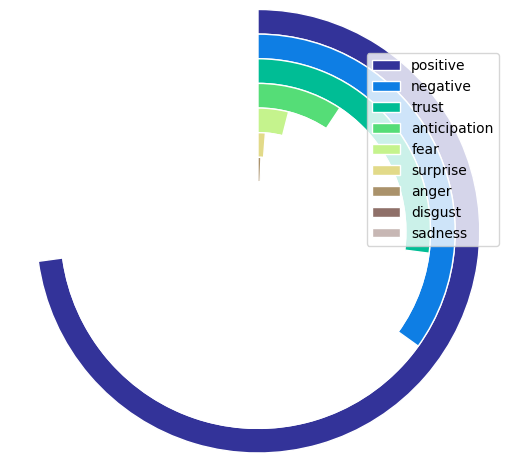

In [84]:
import matplotlib.pyplot as plt
from matplotlib import cm
from math import log10

df_chart = df[df.Emotion != "No emotion"]
labels = df_chart.Emotion.value_counts().index.tolist()
data = df_chart.Emotion.value_counts()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()